In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster
from scipy.stats import multivariate_normal as mvn
from sklearn.metrics import accuracy_score

In [2]:
mu_array = np.asarray([[-1,-1],
                       [1,-1],
                       [0,1]])
S_array = np.asarray([[[2,0.5],[0.5,1]],
                      [[1,-0.5],[-0.5,2]],
                      [[1,0],[0,2]]])

In [3]:
def get_synth_dataset(mu_array, S_array, sigma, N):
    x_0 = np.random.multivariate_normal(mu_array[0].squeeze(), sigma*S_array[0], N)
    y_0 = np.zeros(N, dtype=int)
    x_1 = np.random.multivariate_normal(mu_array[1].squeeze(), sigma*S_array[1], N)
    y_1 = np.ones(N, dtype=int)
    x_2 = np.random.multivariate_normal(mu_array[2].squeeze(), sigma*S_array[2], N)
    y_2 = np.ones(N, dtype=int)*2
    x = np.concatenate((x_0,x_1,x_2),axis=0)
    y = np.concatenate((y_0,y_1,y_2),axis=0)

    return x,y

In [4]:
def log_likelihood(_x, _mu, _cov):
    _log_likelihood = -_x.shape[0] - 1*np.linalg.slogdet(_cov)[1] - (_x-_mu).T@np.linalg.inv(_cov)@(_x-_mu)
    return _log_likelihood*0.5

In [5]:
def EM(X, k, n_iter):
  n = len(X)
  d = X.shape[1]
  
  # initialize model parameters
  mu_array = np.random.multivariate_normal(np.zeros(d), np.eye(d), size=k)
  S_array = np.zeros((k, d, d))
  for i in range(k):
    S_array[i] = np.eye(d)
  pi_array = np.ones(k)/k

  # run EM iterations
  for l in range(n_iter):
    r_array = np.zeros((n, k))
    p_array = np.zeros((n, k))
    for i in range(n):
      tmp = 0
      for j in range(k):
        p_array[i,j] = mvn.pdf(X[i], mean=mu_array[j], cov=S_array[j])
        tmp += p_array[i,j] * pi_array[j]
      for j in range(k):
        r_array[i,j] = (p_array[i,j] * pi_array[j])/tmp
    
    # update pi
    pi_array = np.sum(r_array, axis=0)/n
    
    # update mu
    for j in range(k):
      r_sum = pi_array[j] * n
      tmp = np.zeros_like(X[0])
      for i in range(n):
        tmp += X[i] * r_array[i,j]
      mu_array[j] = tmp/r_sum
    
    # update Sig
    for j in range(k):
      r_sum = pi_array[j] * n
      tmp = np.zeros_like(S_array[0])
      for i in range(n):
        diff = X[i]-mu_array[j]
        diff = diff.reshape((d,1))
        tmp += diff@diff.T * r_array[i,j]
      S_array[j] = tmp/r_sum
  
  return pi_array, mu_array, S_array, r_array

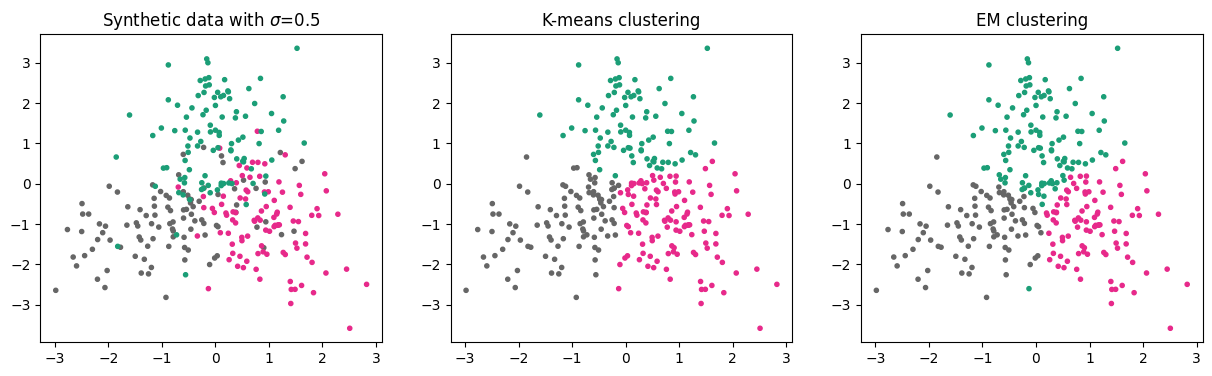

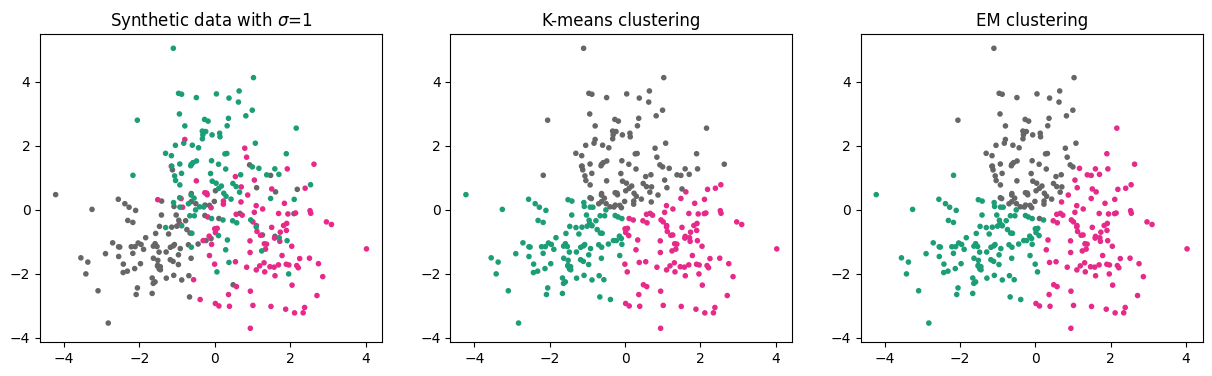

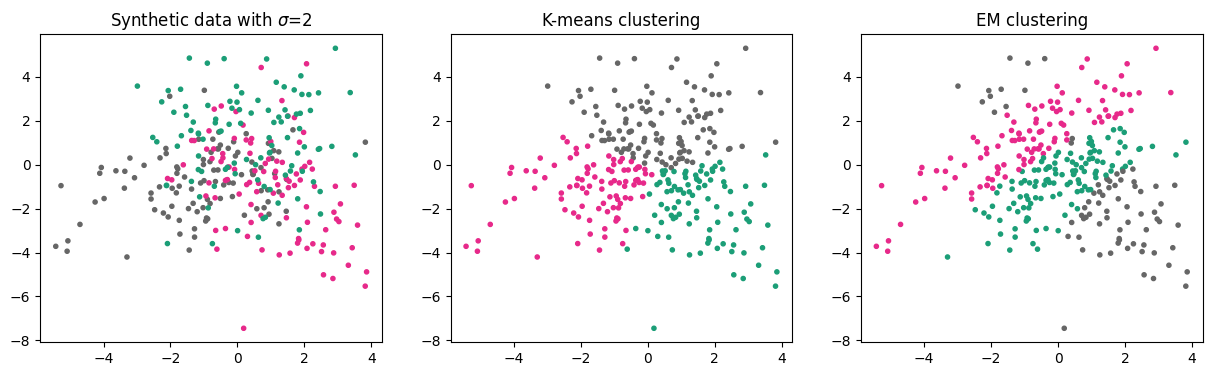

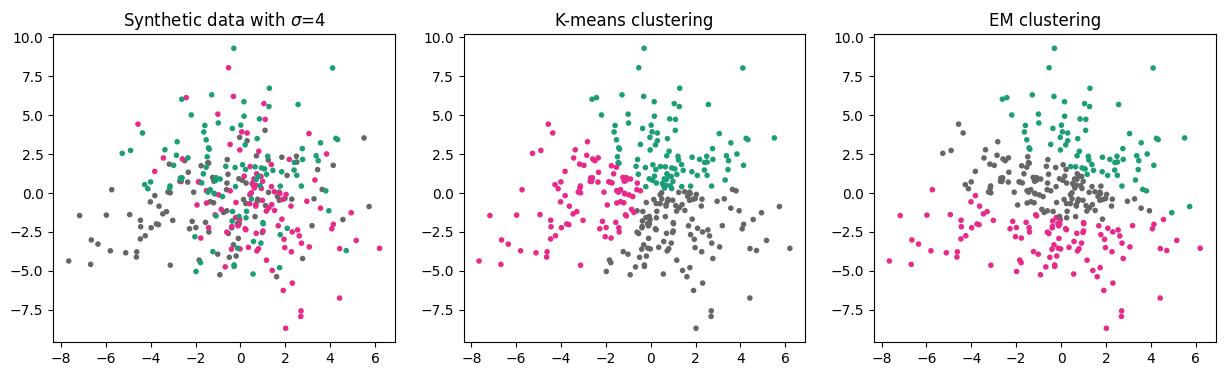

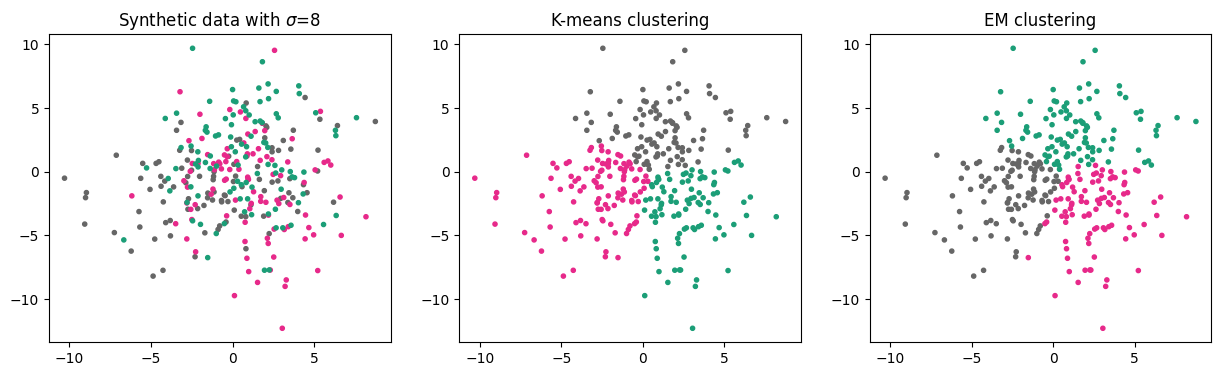

In [6]:
k = 3
interia_kmm = []
acc_score_kmm = []
ll_em = []
acc_score_em = []
sigmas = [0.5,1,2,4,8]
for sigma in sigmas:
    x_train, y_train = get_synth_dataset(mu_array, S_array, sigma, 100)
    fig = plt.figure(figsize=(15, 4))
    ax = fig.add_subplot(131)
    ax.scatter(x_train[:,0], x_train[:,1], c=y_train, cmap='Dark2_r', marker='.')
    ax.title.set_text(f"Synthetic data with $\sigma$={sigma}")

    kmm = cluster.KMeans(n_clusters=k,init='k-means++')
    kmm.fit(x_train)

    y_predict_kmm = kmm.predict(x_train)
    interia_kmm.append(kmm.inertia_)

    label_swap_kmm = [np.argmin(np.linalg.norm(kmm.cluster_centers_ - mu_array[i], axis=1)) for i in range(k)]
    acc_score_kmm.append(accuracy_score([label_swap_kmm[k] for k in y_train], y_predict_kmm))

    d = x_train.shape[1]
    pi_array_em, mu_array_em, S_array_em, r_array_em = EM(x_train, k, 50)

    y_hat = []
    nll = 0
    for i, x in enumerate(x_train):
        ll_ = [log_likelihood(x, mu_array_em[j], S_array_em[j]) for j in range(k)]
        nll += -np.argmax(ll_)
        y_hat.append(np.argmax(ll_))

    ll_em.append(nll)

    label_swap_em = [np.argmin(np.linalg.norm(mu_array_em - mu_array[i], axis=1)) for i in range(k)]
    acc_score_em.append(accuracy_score([label_swap_em[k] for k in y_train], y_hat))
    
    ax = fig.add_subplot(132)
    ax.scatter(x_train[:,0], x_train[:,1], c=y_predict_kmm, cmap='Dark2_r', marker='.')
    ax.title.set_text(f"K-means clustering")

    ax = fig.add_subplot(133)
    ax.scatter(x_train[:,0], x_train[:,1], c=y_hat, cmap='Dark2_r', marker='.')
    ax.title.set_text(f"EM clustering")
    plt.show()

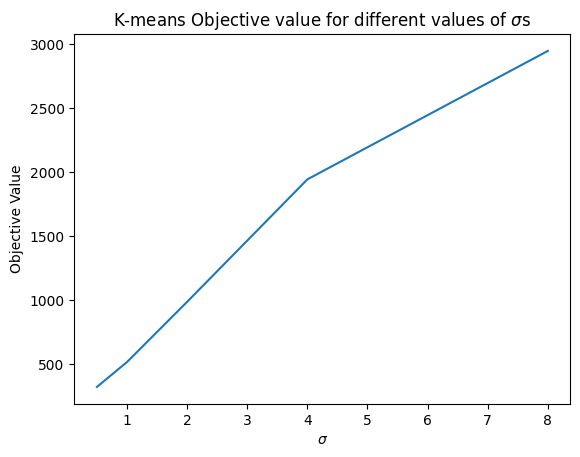

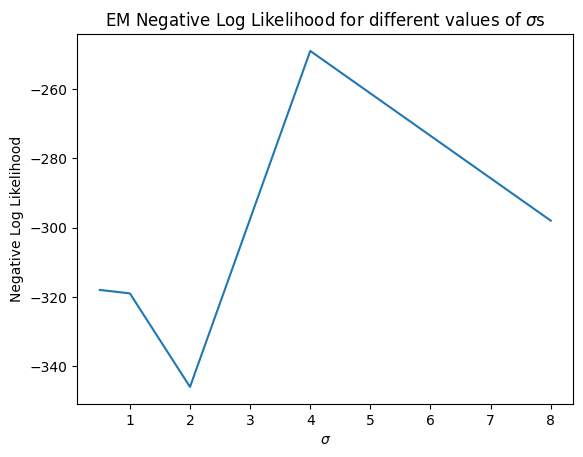

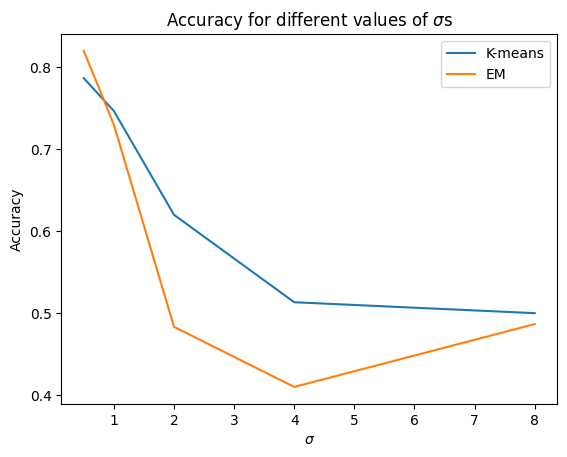

In [7]:
plt.plot(sigmas, interia_kmm, label='K-means')
plt.title("K-means Objective value for different values of $\sigma$s")
plt.xlabel("$\sigma$")
plt.ylabel("Objective Value")
plt.show()

plt.plot(sigmas, ll_em, label='EM')
plt.title("EM Negative Log Likelihood for different values of $\sigma$s")
plt.xlabel("$\sigma$")
plt.ylabel("Negative Log Likelihood")
plt.show()

plt.plot(sigmas, acc_score_kmm, label='K-means')
plt.plot(sigmas, acc_score_em, label='EM')
plt.title("Accuracy for different values of $\sigma$s")
plt.xlabel("$\sigma$")
plt.ylabel("Accuracy")
plt.legend()
plt.show()